In [438]:
# Import the necessary libs for the homework
import torch
from torch import nn 
import matplotlib.pyplot as plt 
import numpy as np 
import math
import pandas as pd
import yfinance as yf


In [452]:

# Import Amazon data from yfinance
stock_data = yf.download("AMZN", start="2015-01-01", end="2020-01-01")

# Extract closing volumes
closing_volumes = stock_data['Close']

# Choose the slicing window
N = 60

# Create a tensor containing the slicing windows of closing volumes
input_sequences = []
for i in range(len(closing_volumes) - N):
    input_sequence = closing_volumes.iloc[i:i+N].values
    input_sequences.append(input_sequence)

train_data = torch.tensor(input_sequences, dtype=torch.float32)

# Convert your data to a TensorDataset using torch.TensorDataset
train_dataset = torch.utils.data.TensorDataset(train_data)

# Define batch size
batch_size = 128

# Create a DataLoader with shuffle=True for shuffling
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for batch in train_loader:
    print(batch[0].size())

[*********************100%%**********************]  1 of 1 completed
torch.Size([128, 60])
torch.Size([128, 60])
torch.Size([128, 60])
torch.Size([128, 60])
torch.Size([128, 60])
torch.Size([128, 60])
torch.Size([128, 60])
torch.Size([128, 60])
torch.Size([128, 60])


In [440]:
# Let's start with the generator as a simple neural network 
class Generator(nn.Module):

     def __init__(self):
         super().__init__()
         self.model = nn.Sequential(
             nn.Linear(N, 2*N), # Input is two dimensional
             nn.ReLU(),
             nn.Linear(2*N, 4*N),
             nn.ReLU(),
             nn.Linear(4*N, 2*N),
             nn.ReLU(),
             nn.Linear(2*N, N),  # Output is N dimensional
         )

     def forward(self, x):
         output = self.model(x)
         return output

# Build the discriminator as a NN
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(N, 256), #the input is lenght N
            nn.ReLU(),
            nn.Dropout(0.3), #droput layers reduce overfitting
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(), # sigmoid activation to represent probability
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [441]:
# Sets the parameters
lr_d = 0.002
lr_g = 0.001
loss_function = nn.BCELoss()
num_epochs = 500

In [459]:
from tqdm import tqdm
# Training loop :

discriminator = Discriminator()
generator = Generator()
gen_loss_vector = []
discr_loss_vector = []
num_epoch_vector = []


optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_d)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_g)


for epoch in tqdm(range(num_epochs)):

    for index, batch in enumerate(train_loader):
        real_data_set = batch[0]

        # Preparing the real data to train the discriminator:
        real_data_label = torch.ones(batch_size,1)

        # Preparing the fake data to train the discriminator: 
        noise_data_set = torch.randn((batch_size, N))
        fake_data_set = generator(noise_data_set)
        fake_data_label = torch.zeros(batch_size, 1)

        # Creating the training samples set:
        training_data_set = torch.cat((real_data_set, fake_data_set))

        # Creating the training labels set:
        training_labels_set = torch.cat((real_data_label, fake_data_label))

        # Train the discriminator:
        discriminator.zero_grad()
        output_discriminator = discriminator(training_data_set)
        loss_discriminator = loss_function(
            output_discriminator, training_labels_set)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Initialising the data for the gznzrator: 
        noise_data_set = torch.randn((batch_size, N))

        # Train the generatot:  
        generator.zero_grad()
        output_generator = generator(noise_data_set)
        output_discriminator_generated = discriminator(output_generator)
        loss_generator = loss_function(torch.sigmoid(output_discriminator_generated), real_data_label)
        # We put label = 1 so that the error we want to minimize is the distance between our generated data and the label 1
        loss_generator.backward()
        optimizer_generator.step()

        # prepares data for loss plot afterwise:
        if i == 0:
            gen_loss_vector.append(float(loss_generator))
            discr_loss_vector.append(float(loss_discriminator))
            num_epoch_vector.append(epoch)

    

        # Show loss
        if epoch % 50 == 0 and index == 0:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

            # Let's plot the first time series of the batch in blue
            time_steps = []
            for time in range(len(real_data_set[0])):
                time_steps.append(time)
            plt.plot(time_steps,real_data_set[0],"-",color='blue')

            generated_samples_for_plotting = output_generator.detach()[0]

            # Plot generated samples in red
            plt.plot(time_steps, generated_samples_for_plotting, "-", color='red')
            plt.show()

            # let's plot the lag 1 return distribution
            # Calculate lag-1 returns
            lag_1_returns = generated_samples_for_plotting[1:] - generated_samples_for_plotting[:-1]

            # Plot the distribution of lag-1 returns
            plt.hist(lag_1_returns, bins=50, color='green', alpha=0.7)
            plt.xlabel('Lag-1 Returns')
            plt.ylabel('Frequency')
            plt.title('Distribution of Lag-1 Returns of Generated Samples')
            plt.show()




  0%|          | 0/500 [00:00<?, ?it/s]

 27%|██▋       | 135/500 [00:23<01:57,  3.12it/s]

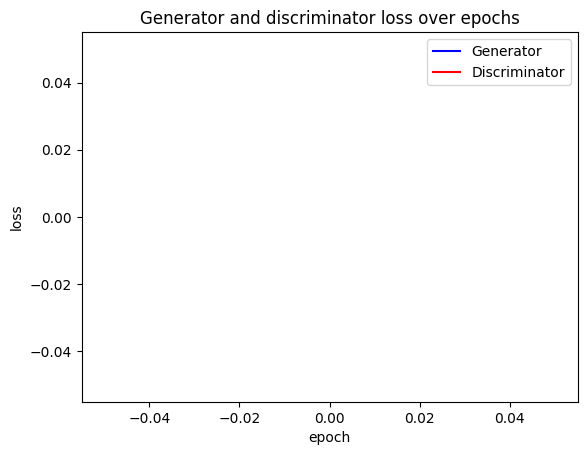

In [443]:
# Plot the functions on the same graph
plt.plot(num_epoch_vector, gen_loss_vector, label='Generator', color = 'b')  
plt.plot(num_epoch_vector, discr_loss_vector, label='Discriminator', color = 'r')  
plt.legend()  
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Generator and discriminator loss over epochs')
plt.show()